In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [3]:
# !pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 8.2 MB/s eta 0:00:00


In [2]:
import ot

/Users/yuksel/anaconda3/envs/cvxpy_env/lib/python3.11/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [3]:
m = 2
n = 3
b=0
M = np.random.normal(0,1,size=(m+n,m+n))
#M += M.T

v=np.argsort(M,axis=1) # sorts per row
print(M)
print(v.shape)
pb = np.random.permutation(m+n)
print(pb)
print(pb[v])
print(pb[v]>=m)
print(np.where(pb[v]>=m))
print(np.kron(np.arange(m+n),np.ones(n)).astype(int))
print(np.repeat(np.arange(m+n),n))
r,c = np.where(pb[v]>=m)
print(v[r,c])

aK_Z_X = M[np.repeat(np.arange(m+n),m),v[pb[v]<m]].reshape(m+n,m)
aK_Z_Y = M[np.repeat(np.arange(m+n),n),v[pb[v]>=m]].reshape(m+n,n)
print(aK_Z_X)
print(aK_Z_Y)


[[-1.69821191  0.88084581  0.45024249  1.45710288 -0.31300294]
 [-0.25654045 -1.71406781  1.29220343 -0.01105987  1.12438969]
 [-0.07206048  0.10428773  0.7279955  -1.02111044 -0.36357246]
 [-0.06740264 -0.32147418  0.99033495  0.71697646 -0.54961646]
 [ 0.84073873  0.80784315 -0.18249431  2.69954469 -0.09492764]]
(5, 5)
[2 0 4 1 3]
[[2 3 4 0 1]
 [0 2 1 3 4]
 [1 3 2 0 4]
 [3 0 2 1 4]
 [4 3 0 2 1]]
[[ True  True  True False False]
 [False  True False  True  True]
 [False  True  True False  True]
 [ True False  True False  True]
 [ True  True False  True False]]
(array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]), array([0, 1, 2, 1, 3, 4, 1, 2, 4, 0, 2, 4, 0, 1, 3]))
[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]
[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]
[0 4 2 0 4 2 4 0 2 4 0 2 2 4 0]
[[ 0.88084581  1.45710288]
 [-1.71406781 -0.01105987]
 [-1.02111044  0.10428773]
 [-0.32147418  0.71697646]
 [ 0.80784315  2.69954469]]
[[-1.69821191 -0.31300294  0.45024249]
 [-0.25654045  1.12438969  1.29220343]
 [-0.36357246 

In [4]:
def MLW(K,x_idx,p_W=2,permutations=None,do_sort_only_once=True, rng=np.random.default_rng(0)):
    m = np.sum(x_idx)
    n = len(x_idx)-m

    K_X_Z = K[x_idx, :]
    K_Y_Z = K[~x_idx, :]
    landmark_idx,div = MLW_sorted(np.sort(K_X_Z,axis=0),np.sort(K_Y_Z,axis=0),p_W)

    if permutations is not None:
        shuffled_tests = np.zeros((permutations, 1))
        if m != n:
            acute_p, acute_i, acute_j = northwest_corner_rule_iid(m,n)

        if do_sort_only_once:
            v=np.argsort(K,axis=1) # sorts per row
            row_X = np.repeat(np.arange(m+n),m)
            row_Y = np.repeat(np.arange(m+n),n)
            for b in range(permutations):
                pb = np.random.permutation(m+n)
                aK_Z_X = K[row_X, v[pb[v]<m] ].reshape(m+n,m)
                aK_Z_Y = K[row_Y, v[pb[v]>=m]].reshape(m+n,n)
                if m==n:
                    shuffled_tests[b] = np.max(np.mean(np.abs(aK_Z_X - aK_Z_Y)**p_W, axis=1))
                else:
                    shuffled_tests[b] = np.max(np.dot(np.abs(aK_Z_X[:,acute_i]-aK_Z_Y[:,acute_j])**p_W, acute_p))
        else:
            for b in range(permutations):
                new_x_idx = x_idx[rng.permutation(len(x_idx))]
#                _,shuffled_tests[b] = MLW(K, new_x_idx, p_W)
                if m==n:
                    shuffled_tests[b] = np.max(np.mean(np.abs(np.sort(K[new_x_idx, :],axis=0) - np.sort(K[~new_x_idx, :],axis=0))**p_W, axis=0))
                else:
                    shuffled_tests[b] = np.max(np.dot(np.abs(np.sort(K[:,new_x_idx],axis=1)[:,acute_i]-np.sort(K[:,~new_x_idx],axis=1)[:,acute_j])**p_W, acute_p))

        pvalue = np.mean(div<=shuffled_tests)
        return landmark_idx, div, pvalue
    else:
        return landmark_idx, div

def northwest_corner_rule_iid(m,n):
    # for sorted don't need data
    acute_p,acute_indices,_ = ot.lp.emd_wrap.emd_1d_sorted(
        np.full(m,1/m),np.full(n,1/n),1.0+np.arange(m),1.0+np.arange(n))
    acute_i, acute_j = acute_indices[:,0],acute_indices[:,1]
    return acute_p, acute_i, acute_j


def MLW_sorted(K_X_Z, K_Y_Z, p_W):
    m = K_X_Z.shape[0]
    n = K_Y_Z.shape[0]

    if m==n:
        landmark_divs = np.mean(np.abs(K_X_Z - K_Y_Z)**p_W, axis=0)
    else:
        acute_p, acute_i, acute_j = northwest_corner_rule_iid(m,n)
        landmark_divs = (acute_p[:,np.newaxis].T@np.abs(K_X_Z[acute_i]-K_Y_Z[acute_j])**p_W).squeeze()

    landmark_idx = np.argmax(landmark_divs)
    return landmark_idx, landmark_divs[landmark_idx]

In [5]:
def LMSKW(X, Y, tests=0):
    if np.sum((Y == 0) | (Y == 1)) == np.size(Y):
        x_idx = Y
        K = X
        m = np.sum(x_idx)
        n = K.shape[0] - m
    else:
        m = X.shape[0]
        n = Y.shape[0]
        x_idx = np.array(range(m+n)) < m

        K, _ = gaussian_kernel(np.concatenate((X, Y), axis=0)) #


    K_X_Z = K[x_idx, :]
    K_Y_Z = K[~x_idx, :]

    if m == n:  # assumes the X and Y are equal size
        # landmark_divs = mean( (sort(K_X_Z) - sort(K_Y_Z)).^2 , 1);
        landmark_divs = np.mean(np.square(np.sort(K_X_Z, axis=0) - np.sort(K_Y_Z, axis=0)), axis=0)
    else:  # if m is not equal to n, mass splitinßg applied for exact corresponding
        m_part = np.linspace(0, 1, m+1)[:,np.newaxis]  # linspace(start,stop,step)
        n_part = np.linspace(0, 1, n+1)[:,np.newaxis].T
        G = np.minimum(m_part, n_part)
        P = np.diff(np.diff(G, axis=0), axis=1)  # matlab: diff(data,nth order,dimention)
        landmark_divs = np.mean(np.square(K_X_Z), axis=0) + np.mean(np.square(K_Y_Z), axis=0) - 2 * np.sum(
            (P.T @ np.sort(K_X_Z,axis=0)) * np.sort(K_Y_Z,axis=0),axis=0)

#    idx = np.unravel_index(np.argmax(landmark_divs, axis=None), landmark_divs.shape)
    idx = np.argmax(landmark_divs)
    max_val = np.max(landmark_divs)
    div_max = np.sqrt(np.maximum(0, max_val))
    alphas = np.zeros((K.shape[0], 1))
    alphas[idx] = 1
    V = K @ alphas

    p_val = 0
    if (tests > 1):
        shuffled_tests = np.zeros((tests, 1))
        K_tilde = np.sort(K, axis=0)
        if m == n:
            for t in range(tests):
                rand_perm = x_idx[np.random.permutation(len(x_idx))]  # bool
                # p2(t,:) = sqrt(max(0,max(mean((K_tilde(rand_perm,:) - K_tilde(~rand_perm,:)).^2,1))));
                shuffled_tests[t] = np.sqrt(np.maximum(0, np.max(
                    np.mean(np.square(K_tilde[rand_perm, :] - K_tilde[~rand_perm, :]), axis=0))))
        else:
            for t in range(tests):
                rand_perm = x_idx[np.random.permutation(len(x_idx))]
                KXZ = K_tilde[rand_perm, :]
                KYZ = K_tilde[~rand_perm, :]
                shuffled_tests[t] = np.sqrt(np.maximum([0], np.max(np.mean(np.square(K_X_Z), axis=0) + np.mean(np.square(K_Y_Z), axis=0) - 2 * np.sum(
            (P.T @ np.sort(K_X_Z,axis=0)) * np.sort(K_Y_Z,axis=0),axis=0))))

        p_val = np.mean(shuffled_tests >= div_max)
        # p_vals = np.array(p_val)
    return p_val, landmark_divs, V, alphas

In [6]:
def gaussian_kernel(X, kernel_size=None):
    n, _ = X.shape  # [n,d] = size(X);
    # X = (n_size * 2, d)
    def rbf2(D2, kernel_size):
       return np.exp(-D2 / (2 * kernel_size ** 2))
    # form pairwise distance matrix (squared Euclidean)
    D2 = np.maximum(0, -2 * (X @ X.T)
                    + np.sum(X**2, axis=1, keepdims=True)
                    + (np.sum(X**2, axis=1, keepdims=True)).T) # n_size * 2, n_size * 2

    # find the median kernel size
    if kernel_size is None:
        kernel_size = np.nanmedian(np.ravel(np.sqrt(D2) + sparse.spdiags(np.nan, 0, n, n)))

    K = rbf2(D2, kernel_size) # n_size * 2, n_size * 2
    K = (K + np.transpose(K)) / 2 # n_size * 2, n_size * 2
    return K, kernel_size

In [7]:
def make_clusters(m,n,n_clusters,prevalence_of_missing=None, rng=np.random.default_rng(0)):
    if prevalence_of_missing is None:
        prevalence_of_missing =0.5/n_clusters

    angles = np.arange(0,2*np.pi,2*np.pi/n_clusters)
    clusters = 8*np.hstack((np.cos(angles)[:,np.newaxis],np.sin(angles)[:,np.newaxis]))

    x_i = rng.choice(n_clusters,size=m)
    p = np.full(n_clusters,(1-prevalence_of_missing)/(n_clusters-1))
    p[-1] = prevalence_of_missing
    y_i = rng.choice(n_clusters,size=n,p=p)
    return rng.normal(0,1,size=(m,2))+clusters[x_i], rng.normal(0,1,size=(n,2))+clusters[y_i]


78 0.003820117220037747
78 0.003820117220037747


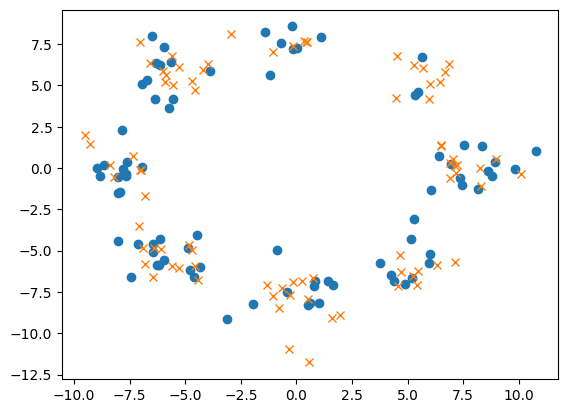

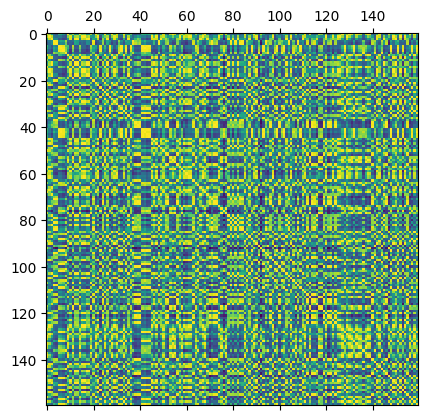

In [8]:
m, n = 80, 80
n_clusters = 8
x,y = make_clusters(m,n,n_clusters)

plt.plot(x[:,0],x[:,1],'o')
plt.plot(y[:,0],y[:,1],'x')

z = np.vstack((x,y))
x_idx = 1==np.concatenate((np.ones(m),np.zeros(n)))
K,kernel_size = gaussian_kernel(z)
plt.matshow(K)


_,divs,_,alphas = LMSKW(K,x_idx)
idx1 = np.flatnonzero(alphas)[0] # should be one
div1 = divs[idx1]
print(idx1,div1)

idx2,div2 = MLW(K,x_idx)
print(idx2,div2)

96 0.013332459370908545
96 0.013332459370908238


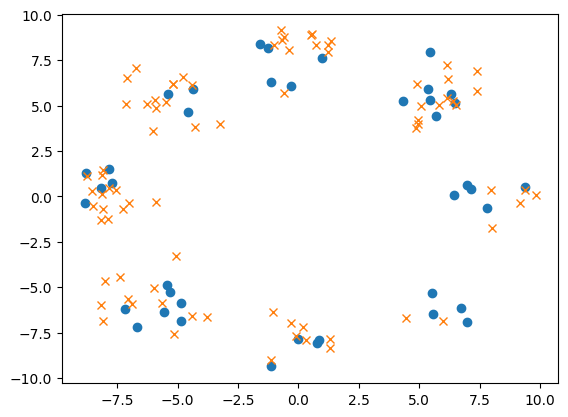

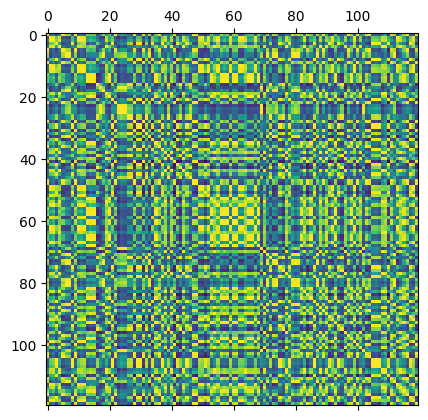

In [9]:
m, n = 40, 80
n_clusters = 8
x,y = make_clusters(m,n,n_clusters,0.025)

plt.plot(x[:,0],x[:,1],'o')
plt.plot(y[:,0],y[:,1],'x')

z = np.vstack((x,y))
x_idx = 1==np.concatenate((np.ones(m),np.zeros(n)))
K,kernel_size = gaussian_kernel(z)
plt.matshow(K)


_,divs,_,alphas = LMSKW(K,x_idx)
idx1 = np.flatnonzero(alphas)[0] # should be one
div1 = divs[idx1]
print(idx1,div1)

idx2,div2 = MLW(K,x_idx)
print(idx2,div2)

In [11]:
import time

330 0.004297353367383578 0.157 0.2664659023284912
330 0.004297353367383578 0.2895 5.1232593059539795
330 0.004297353367383578 0.2835 9.496556997299194


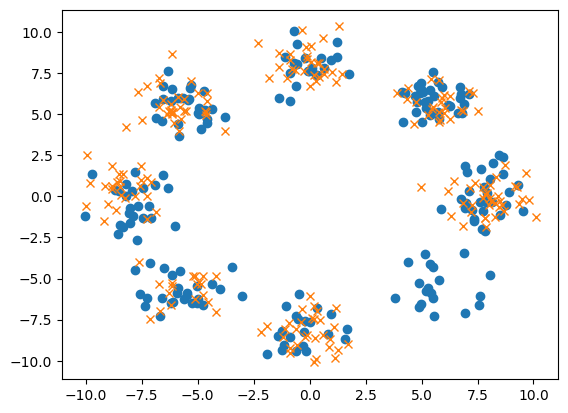

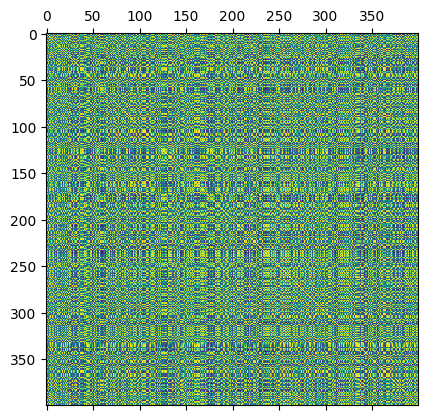

In [12]:
m, n = 200, 200
n_clusters = 8
x,y = make_clusters(m,n,n_clusters,0)

plt.plot(x[:,0],x[:,1],'o')
plt.plot(y[:,0],y[:,1],'x')

z = np.vstack((x,y))
x_idx = 1==np.concatenate((np.ones(m),np.zeros(n)))
K,kernel_size = gaussian_kernel(z)
plt.matshow(K)

n_permutations = 2000



start = time.time()
pvalue1, divs, _, alphas = LMSKW(K, x_idx, n_permutations)
idx1 = np.flatnonzero(alphas)[0]
end = time.time()
print(idx1,divs[idx1],pvalue1,end - start)

start = time.time()
idx3,div3,pvalue3 = MLW(K,x_idx,2,n_permutations,do_sort_only_once=True)
end = time.time()
print(idx3,div3,pvalue3,end - start)


start = time.time()
idx2,div2,pvalue2 = MLW(K,x_idx,2,n_permutations,do_sort_only_once=False)
end = time.time()
print(idx2,div2,pvalue2,end - start)



25 0.007172169235411641 1.0 9.373816967010498
25 0.007172169235411929 0.1415 4.657283067703247
25 0.007172169235411929 0.1305 7.737027883529663


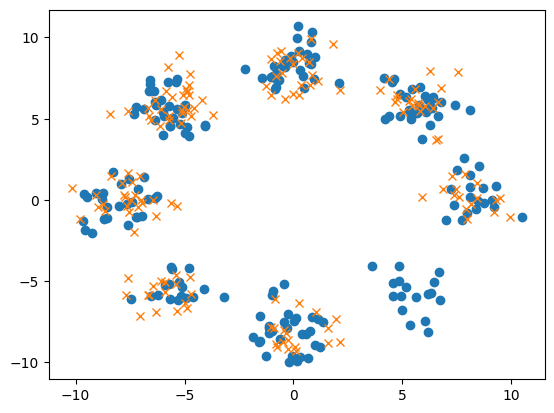

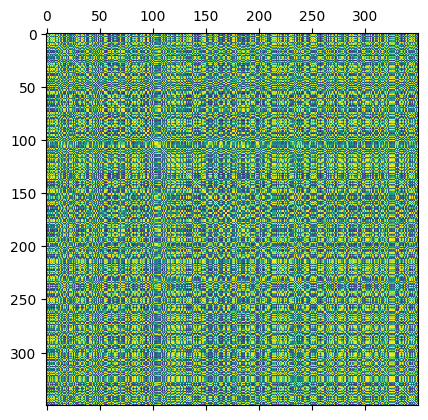

In [13]:
m, n = 200, 150
n_clusters = 8
x,y = make_clusters(m,n,n_clusters,0)

plt.plot(x[:,0],x[:,1],'o')
plt.plot(y[:,0],y[:,1],'x')

z = np.vstack((x,y))
x_idx = 1==np.concatenate((np.ones(m),np.zeros(n)))
K,kernel_size = gaussian_kernel(z)
plt.matshow(K)

n_permutations = 2000



start = time.time()
pvalue1, divs, _, alphas = LMSKW(K, x_idx, n_permutations)
idx1 = np.flatnonzero(alphas)[0]
end = time.time()
print(idx1,divs[idx1],pvalue1,end - start)

start = time.time()
idx3,div3,pvalue3 = MLW(K,x_idx,2,n_permutations,do_sort_only_once=True)
end = time.time()
print(idx3,div3,pvalue3,end - start)


start = time.time()
idx2,div2,pvalue2 = MLW(K,x_idx,2,n_permutations,do_sort_only_once=False)
end = time.time()
print(idx2,div2,pvalue2,end - start)



In [14]:
m, n = 800, 800
n_clusters = 10

monte_carlos = 20
n_permutations = 150

pvalues = np.ones((monte_carlos,2))
for i in range(monte_carlos):
    x,y = make_clusters(m,n,n_clusters,1/n_clusters)

    z = np.vstack((x,y))
    x_idx = 1==np.concatenate((np.ones(m),np.zeros(n)))
    K,kernel_size = gaussian_kernel(z)
    pvalue1, divs, _, alphas = LMSKW(K, x_idx, n_permutations)
    pvalues[i,0] = pvalue1

    _,divs,pvalue1 = MLW(K, x_idx, permutations=n_permutations)
    pvalues[i,1] = pvalue1

In [15]:
print(np.mean(pvalues[:,[0]]<np.array([0.01,0.05,0.1])[np.newaxis,:],axis=0))
print(np.mean(pvalues[:,[1]]<np.array([0.01,0.05,0.1])[np.newaxis,:],axis=0))

[0.   0.15 0.3 ]
[0.   0.   0.05]


Text(0, 0.5, 'New code')

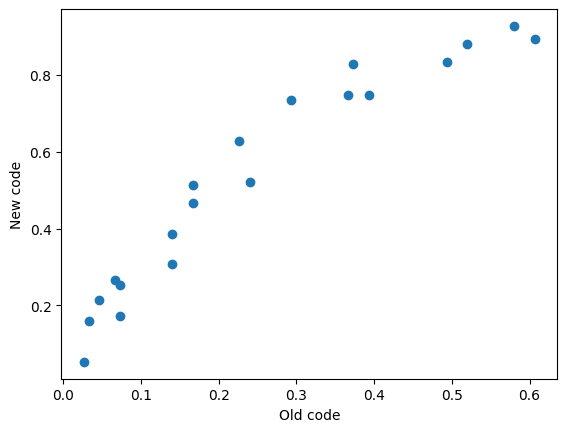

In [16]:
plt.plot(pvalues[:,0],pvalues[:,1],'o')
plt.xlabel('Old code')
plt.ylabel('New code')
